In [1]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Vamos a cargar nuestros datos

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


Podemos ver que el dataset tiene multiples imagenes de multiples elementos como vehiculos, animales, etc

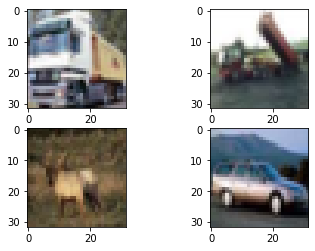

In [4]:
fig, axs = plt.subplots(2, 2) #Crea una matriz 2x2 para los subplots
axs[0,0].imshow(x_train[1])
axs[0,1].imshow(x_train[2])
axs[1,0].imshow(x_train[3])
axs[1,1].imshow(x_train[4])
plt.show()

Vamos a hacer una limpieza de datos comenzando por reducir la dimension de las imagenes. Sabemos que las matrices van de 0 a 255, entonces vamos a volver los numeros de 0 a 1 asi: Se divide al final por 255:
x_train = x_train.astype('float32')/255 al igual que x_test.

Sin embargo, para esta nueva version no se usara

In [5]:
x_train = x_train.astype('float32')  #Quedaran imagenes de 32x32 en 3 distintas capas
x_test = x_test.astype('float32')

Vamos a reducir tambien o reestructurar los arreglos para los labels.

In [6]:
num_clases = len(np.unique(y_train)) #Hay 10 posibles numeros aca
y_train = to_categorical(y_train, num_clases) #To categorical vuelve los valores de clasificacion en un binario
y_test = to_categorical(y_test, num_clases) #Arreglo de 10 posibilidades donde marca el 1 donde esta la clase

In [7]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

### Normalizar ###

Vamos a sacar la media, la desviacion estandar. Luego a la data de entrenamiento le retamos la media sobre la desviacion estandar. Todos los datos quedaran entre 0 y 1



In [8]:
mean = np.mean(x_train) #Media
std = np.std(x_train) #Desviacion Estandar

Se aplicara tambien sobre x test para que queden igualmente normalizados, pero siempre basandonos en x train.
El modelo no debe conocer nunca los datos de prueba en su fase de entrenamiento

In [9]:
x_train = (x_train - mean) / (std*1e-7) #El 1e-7 es para evitar las diviciones por cero.
x_test = (x_test - mean) / (std*1e-7)

Vamos a dividir nuestro set de entrenamiento en set de validacion, entrenamiento y test

In [10]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print('x_train shape:', x_train.shape)

print('train:', x_train.shape[0]) #Usara 45000 imagenes
print('val:', x_valid.shape[0]) #Usara 5000 imagenes
print('test:', x_test.shape[0]) #Usara 10000 imagenes

x_train shape: (45000, 32, 32, 3)
train: 45000
val: 5000
test: 10000


### Creacion de modelo ###


In [11]:
base_filtros = 32
w_regularizer = 1e-4

Todas las capas convolucionales se encargan de la extraccion de datos

In [12]:
model = Sequential()
#Vamos a stakear capas

##CONVOLUCION 1
#en el parentesis hay: (Conv2D(#filtros, tamano de kernel, padding, kernel regularizer))
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer), input_shape=x_train.shape[1:])) 
#capa de activacion Relu
model.add(Activation('relu'))
#Capa de batch normalization
model.add(BatchNormalization())

##CONVOLUCION 2
#No necesita definir entrada porque esta se ve definida por la capa anterior
model.add(Conv2D(base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#Capa de batch normalization
model.add(BatchNormalization())
#capa de maxpooling (Se hara cada 2 capas) para reducir la complejidad del modelo
model.add(MaxPooling2D(pool_size=(2,2))) #El pool size o kernel sera de 2x2
#capa de dropout para vigilar el overfiting
model.add(Dropout(0.2))

##CONVOLUCION 3
#Se hara mas profunda. El doble de filtros
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#Capa de batch normalization
model.add(BatchNormalization())
#capa de dropout
model.add(Dropout(0.2))

##CONVOLUCION 4
model.add(Conv2D(2*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#Capa de batch normalization
model.add(BatchNormalization())
#capa de maxpooling
model.add(MaxPooling2D(pool_size=(2,2)))
#capa de dropout
model.add(Dropout(0.3))

##CONVOLUCION 5
#Aun mas profunda. 4 veces mas filtros
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#Capa de batch normalization
model.add(BatchNormalization())

##CONVOLUCION 6
model.add(Conv2D(4*base_filtros, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regularizer)))
#capa de activacion Relu
model.add(Activation('relu'))
#Capa de batch normalization
model.add(BatchNormalization())
#capa de maxpooling
model.add(MaxPooling2D(pool_size=(2,2)))
#capa de dropout
model.add(Dropout(0.4))

##CLASIFICACION Y FLATTEN
#capa flatten para agregar todo el resultado de la ultima convolucion se va a llevar a una unica dimension
model.add(Flatten())
#capa fully conect densa para la clasificacion de las imagenes
model.add(Dense(num_clases, activation='softmax'))

model.summary()


2023-02-01 11:30:32.309402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.310294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.431594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.432781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.433823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

2023-02-01 11:30:32.794272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.795467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.796585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.797610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 11:30:32.798615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [13]:
datagen = ImageDataGenerator(rotation_range = 15,
                      width_shift_range = 0.1,
                      height_shift_range = 0.1,
                      horizontal_flip = True,
                      vertical_flip = True)

In [14]:
from tensorflow.keras import optimizers

### Compilacion de Modelo ###

Se usara el **optimizador** Adam, el cual se adecua al momentum de la red.
Recordando, el optimizador es el encargado de **generar pesos cada vez mejores** y se basa en calcular el gradiente de la funcion de coste (derivada parcial) por cada peso (parametro / dimension) de la red. 

El conjunto de métodos iterativos de reducción de la función de error (búsqueda de un mínimo local), son conocidos cómo los método de optimización basados en el gradiente descendente.

Adam (Adaptive moment estimation)
El algoritmo Adam combina las bondades de AdaGrad y RMSProp. Se mantiene un factor de entrenamiento por parámetro y además de calcular RMSProp, cada factor de entrenamiento también se ve afectado por la media del momentum del gradiente


In [15]:
model.compile(loss='categorical_crossentropy', 
             optimizer = optimizers.Adam(),
             metrics=['accuracy'])

### Entrenamiento del modelo ###

In [16]:
#El batch size indica que va a tomar lotes de a 32 imagenes por iteracion
#... si hay poquitas imagenes no hay necesidad de darle este paremetro,
#... pero si hay muchas como en este caso, si se debe usar
#A mayor batch size, mas recursos va a consumir.
#hist = model.fit(x_train, y_train, batch_size=32, epochs=100,
#                validation_data=(x_valid, y_valid),
#                verbose=2, shuffle=True) #Como se van a ver los datos, mezcla de datos

Nuevo modelo

In [17]:
#checkpoint para guardar el mejor modelo basado en el monitoreo del accuracy del set de validacion
checkpoint = ModelCheckpoint('mi_mejor_modelo.hdf5', verbose = 1, save_best_only = True, monitor = 'val_accuracy')

In [18]:
#En este nuevo modelo, no ira directamente al set de datos, sino que va a ir a la funcion de generacion de imagenes
#... el cual va a generar imagenes basadas en el set de entrenamiento, para luego validarlas con el set de validacion
hist = model.fit(datagen.flow(x_train, y_train, batch_size = 128),
         callbacks = [checkpoint],
         steps_per_epoch = x_train.shape[0] // 128, #pasos por epoca. El batch size es 128
         epochs = 12,
         verbose = 2,
         validation_data = (x_valid, y_valid))

2023-02-01 11:30:36.782388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2023-02-01 11:30:39.002732: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


351/351 - 32s - loss: 2.2143 - accuracy: 0.3282 - val_loss: 1.9826 - val_accuracy: 0.3610

Epoch 00001: val_accuracy improved from -inf to 0.36100, saving model to mi_mejor_modelo.hdf5
Epoch 2/12
351/351 - 21s - loss: 1.7240 - accuracy: 0.4324 - val_loss: 2.1430 - val_accuracy: 0.3822

Epoch 00002: val_accuracy improved from 0.36100 to 0.38220, saving model to mi_mejor_modelo.hdf5
Epoch 3/12
351/351 - 21s - loss: 1.5606 - accuracy: 0.4977 - val_loss: 1.7941 - val_accuracy: 0.4342

Epoch 00003: val_accuracy improved from 0.38220 to 0.43420, saving model to mi_mejor_modelo.hdf5
Epoch 4/12
351/351 - 21s - loss: 1.4266 - accuracy: 0.5378 - val_loss: 1.5258 - val_accuracy: 0.5430

Epoch 00004: val_accuracy improved from 0.43420 to 0.54300, saving model to mi_mejor_modelo.hdf5
Epoch 5/12
351/351 - 22s - loss: 1.3587 - accuracy: 0.5599 - val_loss: 1.2774 - val_accuracy: 0.5854

Epoch 00005: val_accuracy improved from 0.54300 to 0.58540, saving model to mi_mejor_modelo.hdf5
Epoch 6/12
351/351 

### Visualizacion de comportamiento 

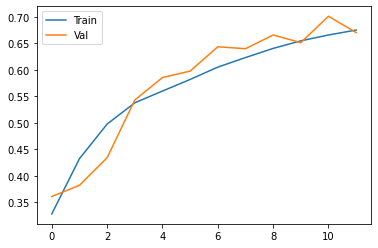

In [19]:
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Val')
plt.legend()
plt.show()

### Evaluacion del modelo ###

In [20]:
model2 = model

In [21]:
model2.load_weights('./mi_mejor_modelo.hdf5')

In [22]:
model2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.9444 - accuracy: 0.6986


[0.944433867931366, 0.6985999941825867]

En este caso llegamos a un accuracy del 70.5%, el cual podría aumentar si tuvieramos mas epocas por ejemplo o si cambiamos algunos de los settings del modelo

Hay varias estrategias que pueden ayudar a subir el accuracy.
Una de ellas es el **Data Augmentation** esto se trata de "aumentar" el set de entrenamiento con las mismas imagenes pero con ciertas alteraciones como: rotacion (con fill mode nearest, reflect o wrap), desplazar la imagen en las 4 direcciones, aumentar o disminuir el brillo de la imagen, hacer zoom en recuadros especificos, etc.